In [1]:
%load_ext autoreload
%autoreload 2

import gc
import logging
import os
import pickle
import sys

import anndata as ad
import numpy as np
import torch
import pandas as pd
import scanpy as sc
import scipy
import yaml
import scipy.sparse as sps
import scipy.io as sio
from os.path import join

import scglue
import seaborn as sns
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

In [2]:
root_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main'

In [3]:
# Path to the data directory
# Path to the data directory
root_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main'
data_dir = "/home/sda1/yanxh/data/DOGMA"

par = {}
par['input_pretrain'] = os.path.join(
    root_dir, 
    'output/pretrain/clue/dogma_StimSplit.clue_train.output_pretrain/')
par['output_pretrain'] = par['input_pretrain']

In [4]:
sys.path.append(os.path.join(root_dir, 'src/match_modality/methods/clue/resources'))
import utils

In [5]:
print('Reading `mtx` files...')
rna_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'RNA/rna_mat_count.mtx')).T)
adt_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'ADT/adt_mat_count.mtx')).T)
atac_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'ATAC/atac_mat_count.mtx')).T)

rna_names = pd.read_csv(join(data_dir, 'RNA/hvg_names.csv'))['VariableFeatures(data_ref)'].to_numpy()
adt_names = pd.read_csv(join(data_dir, 'ADT/adt_names.csv'))['VariableFeatures(data_ref)'].to_numpy()
atac_names = pd.read_csv(join(data_dir, 'ATAC/hvp_names.csv'))['VariableFeatures(data_ref)'].to_numpy()

cell_names = pd.read_csv(join(data_dir, 'cell_names.csv'))['x'].to_numpy()
meta_data = pd.read_csv(join(data_dir, 'metadata.csv'), index_col=0)
meta_data = meta_data[['stim', 'predicted.celltype.l1', 'predicted.celltype.l2']].copy()
meta_data.columns = ['batch', 'cell_type', 'cell_type.l2']

train_idx = np.where((meta_data.batch=='Control').to_numpy())[0]
test_idx  = np.where((meta_data.batch=='Stim').to_numpy())[0]

rna_count_mat.shape, adt_count_mat.shape, atac_count_mat.shape, train_idx.size, test_idx.size

Reading `mtx` files...


((13763, 2000), (13763, 210), (13763, 50285), 7624, 6139)

In [6]:
print('Reading `h5ad` files...')
ad_mult_rna = sc.AnnData(sps.csr_matrix(rna_count_mat[train_idx]), obs=meta_data.iloc[train_idx])
ad_mult_adt = sc.AnnData(sps.csr_matrix(adt_count_mat[train_idx]), obs=meta_data.iloc[train_idx])
ad_mult_atac = sc.AnnData(sps.csr_matrix(atac_count_mat[train_idx]), obs=meta_data.iloc[train_idx])

ad_rna_test = sc.AnnData(sps.csr_matrix(rna_count_mat[test_idx]), obs=meta_data.iloc[test_idx])
ad_adt_test = sc.AnnData(sps.csr_matrix(adt_count_mat[test_idx]), obs=meta_data.iloc[test_idx])
ad_atac_test = sc.AnnData(sps.csr_matrix(atac_count_mat[test_idx]), obs=meta_data.iloc[test_idx])

ad_mult_rna.var_names = ad_rna_test.var_names = rna_names
ad_mult_adt.var_names = ad_adt_test.var_names= adt_names
ad_mult_atac.var_names = ad_atac_test.var_names = atac_names

ad_mult_rna.layers["counts"] = ad_mult_rna.X.astype(np.float32)
ad_mult_adt.layers["counts"] = ad_mult_adt.X.astype(np.float32)
ad_mult_atac.layers["counts"] = ad_mult_atac.X.astype(np.float32)
ad_rna_test.layers["counts"] = ad_rna_test.X.astype(np.float32)
ad_adt_test.layers["counts"] = ad_adt_test.X.astype(np.float32)
ad_atac_test.layers["counts"] = ad_atac_test.X.astype(np.float32)

mod1_feature_type = 'GEX'
mod2_feature_type = 'ADT'
mod3_feature_type = 'ATAC'
omics = 'cite'

Reading `h5ad` files...


# shuffling test data

In [7]:
test_shuffle_idx1 = np.arange(ad_rna_test.shape[0])
np.random.shuffle(test_shuffle_idx1)
test_reorder_idx1 = np.argsort(test_shuffle_idx1)

test_shuffle_idx2 = np.arange(ad_adt_test.shape[0])
np.random.shuffle(test_shuffle_idx2)
test_reorder_idx2 = np.argsort(test_shuffle_idx2)

test_shuffle_idx3 = np.arange(ad_atac_test.shape[0])
np.random.shuffle(test_shuffle_idx3)
test_reorder_idx3 = np.argsort(test_shuffle_idx3)

In [8]:
ad_rna_test = ad_rna_test[test_shuffle_idx1].copy()
ad_adt_test = ad_adt_test[test_shuffle_idx2].copy()
ad_atac_test = ad_atac_test[test_shuffle_idx3].copy()

In [9]:
ad_mult_rna.obs["uid"] = [f"train-{i}" for i in range(ad_mult_rna.shape[0])]
ad_mult_adt.obs["uid"] = [f"train-{i}" for i in range(ad_mult_adt.shape[0])]
ad_mult_atac.obs["uid"] = [f"train-{i}" for i in range(ad_mult_atac.shape[0])]
ad_rna_test.obs["uid"] = [f"test-gex-{i}" for i in range(ad_rna_test.shape[0])]
ad_adt_test.obs["uid"] = [f"test-adt-{i}" for i in range(ad_adt_test.shape[0])]
ad_atac_test.obs["uid"] = [f"test-atac-{i}" for i in range(ad_atac_test.shape[0])]
ad_rna_test.obs_names = [f"rna-{i}" for i in ad_rna_test.obs_names.to_numpy()]
ad_adt_test.obs_names = [f"adt-{i}" for i in ad_adt_test.obs_names.to_numpy()]
ad_atac_test.obs_names = [f"atac-{i}" for i in ad_atac_test.obs_names.to_numpy()]

def set_domain(ads, obs_key, uns_key, domains):
    for i in range(len(ads)):
        ads[i].obs[obs_key] = domains[i]
        ads[i].uns[uns_key] = domains[i]
    return ads

In [10]:
logging.info('Concatenating training and test data...')
input_gex = ad.concat(
    {"train": ad_mult_rna, "test": ad_rna_test},
    axis=0, join="outer", merge="same", label="group",
    fill_value=0, index_unique="-"
)
input_gex.uns["feature_type"] = 'GEX'
del ad_mult_rna, ad_rna_test
gc.collect()

input_adt = ad.concat(
    {"train": ad_mult_adt, "test": ad_adt_test},
    axis=0, join="outer", merge="same", label="group",
    fill_value=0, index_unique="-"
)
input_adt.uns["feature_type"] = 'ADT'
del ad_mult_adt, ad_adt_test
gc.collect()

input_atac = ad.concat(
    {"train": ad_mult_atac, "test": ad_atac_test},
    axis=0, join="outer", merge="same", label="group",
    fill_value=0, index_unique="-"
)
input_atac.uns["feature_type"] = 'ATAC'
del ad_mult_atac, ad_atac_test
gc.collect()

INFO:root:Concatenating training and test data...


123

In [11]:
logging.info('Reading preprocessors...')
with open(os.path.join(
        par['input_pretrain'], "prep.pickle"
), "rb") as f:
    prep = pickle.load(f)
    gex_prep = prep["gex_prep"]
    adt_prep = prep["adt_prep"]
    atac_prep = prep['atac_prep']

INFO:root:Reading preprocessors...


In [12]:
logging.info('Preprocessing...')
gex_prep.transform(input_gex)
adt_prep.transform(input_adt)
atac_prep.transform(input_atac)

INFO:root:Preprocessing...


In [13]:
input_gex.obsm['X_pca'].max(), input_gex.obsm['X_pca'].min()

(54.22042391351258, -36.60934772951498)

### Configure datasets

In [14]:
scglue.models.configure_dataset(
    input_gex, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_batch="batch", use_uid="uid"
)
scglue.models.configure_dataset(
    input_adt, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_batch="batch", use_uid="uid"
)
scglue.models.configure_dataset(
    input_atac, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_lsi",
    use_batch="batch", use_uid="uid"
)

In [15]:
with open(os.path.join(
        par['input_pretrain'], "hyperparams.yaml"
), "r") as f:
    hyperparams = yaml.load(f, Loader=yaml.Loader)

logging.info('Building model...')
model = scglue.models.SCCLUEModel(
    {"gex": input_gex, "adt": input_adt, "atac":input_atac},
    latent_dim=hyperparams["latent_dim"],
    x2u_h_depth=hyperparams["x2u_h_depth"],
    x2u_h_dim=hyperparams["x2u_h_dim"],
    u2x_h_depth=hyperparams["u2x_h_depth"],
    u2x_h_dim=hyperparams["u2x_h_dim"],
    du_h_depth=hyperparams["du_h_depth"],
    du_h_dim=hyperparams["du_h_dim"],
    dropout=hyperparams["dropout"],
    shared_batches=True,
    random_seed=hyperparams["random_seed"]
)
print(model.net)


INFO:root:Building model...


[INFO] autodevice: Using GPU 0 as computation device.


INFO:autodevice:Using GPU 0 as computation device.


SCCLUE(
  (x2u): ModuleDict(
    (gex): NBCompositeDataEncoder(
      (encoders): ModuleList(
        (0): ElementDataEncoder(
          (linear_0): Linear(in_features=100, out_features=512, bias=True)
          (act_0): LeakyReLU(negative_slope=0.2)
          (bn_0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout_0): Dropout(p=0.2, inplace=False)
          (linear_1): Linear(in_features=512, out_features=512, bias=True)
          (act_1): LeakyReLU(negative_slope=0.2)
          (bn_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout_1): Dropout(p=0.2, inplace=False)
          (loc): Linear(in_features=512, out_features=20, bias=True)
          (std_lin): Linear(in_features=512, out_features=20, bias=True)
        )
        (1): ElementDataEncoder(
          (linear_0): Linear(in_features=100, out_features=512, bias=True)
          (act_0): LeakyReLU(negative_slope=0.2)
          (b

In [16]:
logging.info('Adopting pretrained weights...')
model.adopt_pretrained_model(scglue.models.load_model(os.path.join(
    par['input_pretrain'], "pretrain.dill"
)))

INFO:root:Adopting pretrained weights...


[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: encoders.2.linear_0.weight


INFO:Transferrable:Copied: encoders.2.linear_0.weight


[INFO] Transferrable: Copied: encoders.2.linear_0.bias


INFO:Transferrable:Copied: encoders.2.linear_0.bias


[INFO] Transferrable: Copied: encoders.2.bn_0.weight


INFO:Transferrable:Copied: encoders.2.bn_0.weight


[INFO] Transferrable: Copied: encoders.2.bn_0.bias


INFO:Transferrable:Copied: encoders.2.bn_0.bias


[INFO] Transferrable: Copied: encoders.2.linear_1.weight


INFO:Transferrable:Copied: encoders.2.linear_1.weight


[INFO] Transferrable: Copied: encoders.2.linear_1.bias


INFO:Transferrable:Copied: encoders.2.linear_1.bias


[INFO] Transferrable: Copied: encoders.2.bn_1.weight


INFO:Transferrable:Copied: encoders.2.bn_1.weight


[INFO] Transferrable: Copied: encoders.2.bn_1.bias


INFO:Transferrable:Copied: encoders.2.bn_1.bias


[INFO] Transferrable: Copied: encoders.2.loc.weight


INFO:Transferrable:Copied: encoders.2.loc.weight


[INFO] Transferrable: Copied: encoders.2.loc.bias


INFO:Transferrable:Copied: encoders.2.loc.bias


[INFO] Transferrable: Copied: encoders.2.std_lin.weight


INFO:Transferrable:Copied: encoders.2.std_lin.weight


[INFO] Transferrable: Copied: encoders.2.std_lin.bias


INFO:Transferrable:Copied: encoders.2.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.2.bn_0.running_mean


INFO:Transferrable:Copied: encoders.2.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.2.bn_0.running_var


INFO:Transferrable:Copied: encoders.2.bn_0.running_var


[INFO] Transferrable: Copied: encoders.2.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.2.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.2.bn_1.running_mean


INFO:Transferrable:Copied: encoders.2.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.2.bn_1.running_var


INFO:Transferrable:Copied: encoders.2.bn_1.running_var


[INFO] Transferrable: Copied: encoders.2.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.2.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: encoders.2.linear_0.weight


INFO:Transferrable:Copied: encoders.2.linear_0.weight


[INFO] Transferrable: Copied: encoders.2.linear_0.bias


INFO:Transferrable:Copied: encoders.2.linear_0.bias


[INFO] Transferrable: Copied: encoders.2.bn_0.weight


INFO:Transferrable:Copied: encoders.2.bn_0.weight


[INFO] Transferrable: Copied: encoders.2.bn_0.bias


INFO:Transferrable:Copied: encoders.2.bn_0.bias


[INFO] Transferrable: Copied: encoders.2.linear_1.weight


INFO:Transferrable:Copied: encoders.2.linear_1.weight


[INFO] Transferrable: Copied: encoders.2.linear_1.bias


INFO:Transferrable:Copied: encoders.2.linear_1.bias


[INFO] Transferrable: Copied: encoders.2.bn_1.weight


INFO:Transferrable:Copied: encoders.2.bn_1.weight


[INFO] Transferrable: Copied: encoders.2.bn_1.bias


INFO:Transferrable:Copied: encoders.2.bn_1.bias


[INFO] Transferrable: Copied: encoders.2.loc.weight


INFO:Transferrable:Copied: encoders.2.loc.weight


[INFO] Transferrable: Copied: encoders.2.loc.bias


INFO:Transferrable:Copied: encoders.2.loc.bias


[INFO] Transferrable: Copied: encoders.2.std_lin.weight


INFO:Transferrable:Copied: encoders.2.std_lin.weight


[INFO] Transferrable: Copied: encoders.2.std_lin.bias


INFO:Transferrable:Copied: encoders.2.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.2.bn_0.running_mean


INFO:Transferrable:Copied: encoders.2.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.2.bn_0.running_var


INFO:Transferrable:Copied: encoders.2.bn_0.running_var


[INFO] Transferrable: Copied: encoders.2.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.2.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.2.bn_1.running_mean


INFO:Transferrable:Copied: encoders.2.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.2.bn_1.running_var


INFO:Transferrable:Copied: encoders.2.bn_1.running_var


[INFO] Transferrable: Copied: encoders.2.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.2.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: encoders.2.linear_0.weight


INFO:Transferrable:Copied: encoders.2.linear_0.weight


[INFO] Transferrable: Copied: encoders.2.linear_0.bias


INFO:Transferrable:Copied: encoders.2.linear_0.bias


[INFO] Transferrable: Copied: encoders.2.bn_0.weight


INFO:Transferrable:Copied: encoders.2.bn_0.weight


[INFO] Transferrable: Copied: encoders.2.bn_0.bias


INFO:Transferrable:Copied: encoders.2.bn_0.bias


[INFO] Transferrable: Copied: encoders.2.linear_1.weight


INFO:Transferrable:Copied: encoders.2.linear_1.weight


[INFO] Transferrable: Copied: encoders.2.linear_1.bias


INFO:Transferrable:Copied: encoders.2.linear_1.bias


[INFO] Transferrable: Copied: encoders.2.bn_1.weight


INFO:Transferrable:Copied: encoders.2.bn_1.weight


[INFO] Transferrable: Copied: encoders.2.bn_1.bias


INFO:Transferrable:Copied: encoders.2.bn_1.bias


[INFO] Transferrable: Copied: encoders.2.loc.weight


INFO:Transferrable:Copied: encoders.2.loc.weight


[INFO] Transferrable: Copied: encoders.2.loc.bias


INFO:Transferrable:Copied: encoders.2.loc.bias


[INFO] Transferrable: Copied: encoders.2.std_lin.weight


INFO:Transferrable:Copied: encoders.2.std_lin.weight


[INFO] Transferrable: Copied: encoders.2.std_lin.bias


INFO:Transferrable:Copied: encoders.2.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.2.bn_0.running_mean


INFO:Transferrable:Copied: encoders.2.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.2.bn_0.running_var


INFO:Transferrable:Copied: encoders.2.bn_0.running_var


[INFO] Transferrable: Copied: encoders.2.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.2.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.2.bn_1.running_mean


INFO:Transferrable:Copied: encoders.2.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.2.bn_1.running_var


INFO:Transferrable:Copied: encoders.2.bn_1.running_var


[INFO] Transferrable: Copied: encoders.2.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.2.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: linear_1.weight


INFO:BatchedTransferrable:Copied: linear_1.weight


[INFO] BatchedTransferrable: Copied: linear_1.bias


INFO:BatchedTransferrable:Copied: linear_1.bias


[INFO] BatchedTransferrable: Copied: pred.weight


INFO:BatchedTransferrable:Copied: pred.weight


[INFO] BatchedTransferrable: Copied: pred.bias


INFO:BatchedTransferrable:Copied: pred.bias


In [17]:
logging.info('Compiling model...')
model.compile(
    lam_data=hyperparams["lam_data"],
    lam_kl=hyperparams["lam_kl"],
    lam_align=hyperparams["lam_align"],
    lam_cross=hyperparams["lam_cross"],
    lam_cos=hyperparams["lam_cos"],
    normalize_u=hyperparams["normalize_u"],
    domain_weight={"gex": 1, "adt": 1, 'atac':1},
    lr=1e-3  # TODO: Fine-tuning learning rate
)

INFO:root:Compiling model...


In [18]:
if False:
    logging.info('Training model...')
    model.fit(
        {"gex": input_gex, "adt": input_adt, "atac":input_atac},
        align_burnin=0, max_epochs=50,  # 50 or 5
        patience=8, reduce_lr_patience=3
    )

    model.save(os.path.join(par['input_pretrain'], "train.dill"))
else:
    model.adopt_pretrained_model(scglue.models.load_model(os.path.join(
        par['input_pretrain'], "train.dill"
    )))

[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: encoders.2.linear_0.weight


INFO:Transferrable:Copied: encoders.2.linear_0.weight


[INFO] Transferrable: Copied: encoders.2.linear_0.bias


INFO:Transferrable:Copied: encoders.2.linear_0.bias


[INFO] Transferrable: Copied: encoders.2.bn_0.weight


INFO:Transferrable:Copied: encoders.2.bn_0.weight


[INFO] Transferrable: Copied: encoders.2.bn_0.bias


INFO:Transferrable:Copied: encoders.2.bn_0.bias


[INFO] Transferrable: Copied: encoders.2.linear_1.weight


INFO:Transferrable:Copied: encoders.2.linear_1.weight


[INFO] Transferrable: Copied: encoders.2.linear_1.bias


INFO:Transferrable:Copied: encoders.2.linear_1.bias


[INFO] Transferrable: Copied: encoders.2.bn_1.weight


INFO:Transferrable:Copied: encoders.2.bn_1.weight


[INFO] Transferrable: Copied: encoders.2.bn_1.bias


INFO:Transferrable:Copied: encoders.2.bn_1.bias


[INFO] Transferrable: Copied: encoders.2.loc.weight


INFO:Transferrable:Copied: encoders.2.loc.weight


[INFO] Transferrable: Copied: encoders.2.loc.bias


INFO:Transferrable:Copied: encoders.2.loc.bias


[INFO] Transferrable: Copied: encoders.2.std_lin.weight


INFO:Transferrable:Copied: encoders.2.std_lin.weight


[INFO] Transferrable: Copied: encoders.2.std_lin.bias


INFO:Transferrable:Copied: encoders.2.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.2.bn_0.running_mean


INFO:Transferrable:Copied: encoders.2.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.2.bn_0.running_var


INFO:Transferrable:Copied: encoders.2.bn_0.running_var


[INFO] Transferrable: Copied: encoders.2.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.2.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.2.bn_1.running_mean


INFO:Transferrable:Copied: encoders.2.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.2.bn_1.running_var


INFO:Transferrable:Copied: encoders.2.bn_1.running_var


[INFO] Transferrable: Copied: encoders.2.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.2.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: encoders.2.linear_0.weight


INFO:Transferrable:Copied: encoders.2.linear_0.weight


[INFO] Transferrable: Copied: encoders.2.linear_0.bias


INFO:Transferrable:Copied: encoders.2.linear_0.bias


[INFO] Transferrable: Copied: encoders.2.bn_0.weight


INFO:Transferrable:Copied: encoders.2.bn_0.weight


[INFO] Transferrable: Copied: encoders.2.bn_0.bias


INFO:Transferrable:Copied: encoders.2.bn_0.bias


[INFO] Transferrable: Copied: encoders.2.linear_1.weight


INFO:Transferrable:Copied: encoders.2.linear_1.weight


[INFO] Transferrable: Copied: encoders.2.linear_1.bias


INFO:Transferrable:Copied: encoders.2.linear_1.bias


[INFO] Transferrable: Copied: encoders.2.bn_1.weight


INFO:Transferrable:Copied: encoders.2.bn_1.weight


[INFO] Transferrable: Copied: encoders.2.bn_1.bias


INFO:Transferrable:Copied: encoders.2.bn_1.bias


[INFO] Transferrable: Copied: encoders.2.loc.weight


INFO:Transferrable:Copied: encoders.2.loc.weight


[INFO] Transferrable: Copied: encoders.2.loc.bias


INFO:Transferrable:Copied: encoders.2.loc.bias


[INFO] Transferrable: Copied: encoders.2.std_lin.weight


INFO:Transferrable:Copied: encoders.2.std_lin.weight


[INFO] Transferrable: Copied: encoders.2.std_lin.bias


INFO:Transferrable:Copied: encoders.2.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.2.bn_0.running_mean


INFO:Transferrable:Copied: encoders.2.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.2.bn_0.running_var


INFO:Transferrable:Copied: encoders.2.bn_0.running_var


[INFO] Transferrable: Copied: encoders.2.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.2.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.2.bn_1.running_mean


INFO:Transferrable:Copied: encoders.2.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.2.bn_1.running_var


INFO:Transferrable:Copied: encoders.2.bn_1.running_var


[INFO] Transferrable: Copied: encoders.2.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.2.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: encoders.2.linear_0.weight


INFO:Transferrable:Copied: encoders.2.linear_0.weight


[INFO] Transferrable: Copied: encoders.2.linear_0.bias


INFO:Transferrable:Copied: encoders.2.linear_0.bias


[INFO] Transferrable: Copied: encoders.2.bn_0.weight


INFO:Transferrable:Copied: encoders.2.bn_0.weight


[INFO] Transferrable: Copied: encoders.2.bn_0.bias


INFO:Transferrable:Copied: encoders.2.bn_0.bias


[INFO] Transferrable: Copied: encoders.2.linear_1.weight


INFO:Transferrable:Copied: encoders.2.linear_1.weight


[INFO] Transferrable: Copied: encoders.2.linear_1.bias


INFO:Transferrable:Copied: encoders.2.linear_1.bias


[INFO] Transferrable: Copied: encoders.2.bn_1.weight


INFO:Transferrable:Copied: encoders.2.bn_1.weight


[INFO] Transferrable: Copied: encoders.2.bn_1.bias


INFO:Transferrable:Copied: encoders.2.bn_1.bias


[INFO] Transferrable: Copied: encoders.2.loc.weight


INFO:Transferrable:Copied: encoders.2.loc.weight


[INFO] Transferrable: Copied: encoders.2.loc.bias


INFO:Transferrable:Copied: encoders.2.loc.bias


[INFO] Transferrable: Copied: encoders.2.std_lin.weight


INFO:Transferrable:Copied: encoders.2.std_lin.weight


[INFO] Transferrable: Copied: encoders.2.std_lin.bias


INFO:Transferrable:Copied: encoders.2.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.2.bn_0.running_mean


INFO:Transferrable:Copied: encoders.2.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.2.bn_0.running_var


INFO:Transferrable:Copied: encoders.2.bn_0.running_var


[INFO] Transferrable: Copied: encoders.2.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.2.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.2.bn_1.running_mean


INFO:Transferrable:Copied: encoders.2.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.2.bn_1.running_var


INFO:Transferrable:Copied: encoders.2.bn_1.running_var


[INFO] Transferrable: Copied: encoders.2.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.2.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: linear_1.weight


INFO:BatchedTransferrable:Copied: linear_1.weight


[INFO] BatchedTransferrable: Copied: linear_1.bias


INFO:BatchedTransferrable:Copied: linear_1.bias


[INFO] BatchedTransferrable: Copied: pred.weight


INFO:BatchedTransferrable:Copied: pred.weight


[INFO] BatchedTransferrable: Copied: pred.bias


INFO:BatchedTransferrable:Copied: pred.bias


In [19]:
# model.adopt_pretrained_model(scglue.models.load_model(os.path.join(
#     par['input_pretrain'], "train.dill"
# )))

In [20]:
# logging.info('Projecting cell embeddings...')
# gex.obsm["X_model"] = modela.encode_data("gex", gex)
# other.obsm["X_model"] = model.encode_data("other", other)

# Evaluation

In [19]:
import sys
sys.path.insert(0, '/home/yanxh/gitrepo/multi-omics-matching/ACE/reproduce/evaluation')

from evaluation import eval_mosaic, eval_specific_mod, eval_bridge, print_results, eval_asw, eval_lisi, eval_clustering
from evaluation import eval_bridge_above2

In [20]:
gex_enc = model.encode_data('gex', input_gex[input_gex.obs["group"] == "test"])
adt_enc = model.encode_data('adt', input_adt[input_adt.obs["group"] == "test"])
atac_enc = model.encode_data('atac', input_atac[input_atac.obs["group"] == "test"])

gex_train_enc = model.encode_data('gex', input_gex[input_gex.obs["group"] == "train"])
adt_train_enc = model.encode_data('adt', input_adt[input_adt.obs["group"] == "train"])
atac_train_enc = model.encode_data('atac', input_atac[input_atac.obs["group"] == "train"])

In [21]:
ad_rna_test = input_gex[input_gex.obs["group"] == "test"].copy()
ad_adt_test = input_adt[input_adt.obs["group"] == "test"].copy()
ad_atac_test = input_atac[input_atac.obs["group"] == "test"].copy()
ad_mult_rna = input_gex[input_gex.obs["group"] == "train"].copy()
ad_mult_adt = input_adt[input_adt.obs["group"] == "train"].copy()
ad_mult_atac = input_atac[input_atac.obs["group"] == "train"].copy()

In [22]:
ad_rna_test.obsm['X_model'] = gex_enc
ad_adt_test.obsm['X_model'] = adt_enc
ad_atac_test.obsm['X_model'] = atac_enc

ad_mult_rna.obsm['X_model'] = gex_train_enc
ad_mult_adt.obsm['X_model'] = adt_train_enc
ad_mult_atac.obsm['X_model'] = atac_train_enc

ad_mult_rna, ad_rna_test = set_domain([ad_mult_rna, ad_rna_test], obs_key='domain', uns_key='domain', domains=['multiome', 'gex'])
ad_mult_adt, ad_adt_test = set_domain([ad_mult_adt, ad_adt_test], obs_key='domain', uns_key='domain', domains=['multiome', 'adt'])
ad_mult_atac, ad_atac_test = set_domain([ad_mult_atac, ad_atac_test], obs_key='domain', uns_key='domain', domains=['multiome', 'atac'])

ad_mult_rna.obs['mod-batch'] = (ad_mult_rna.obs.domain + '-' + ad_mult_rna.obs.batch).to_numpy()
ad_mult_adt.obs['mod-batch'] = (ad_mult_adt.obs.domain + '-' + ad_mult_adt.obs.batch).to_numpy()
ad_mult_atac.obs['mod-batch'] = (ad_mult_atac.obs.domain + '-' + ad_mult_atac.obs.batch).to_numpy()
ad_rna_test.obs['mod-batch'] = (ad_rna_test.obs.domain + '-' + ad_rna_test.obs.batch).to_numpy()
ad_adt_test.obs['mod-batch'] = (ad_adt_test.obs.domain + '-' + ad_adt_test.obs.batch).to_numpy()
ad_atac_test.obs['mod-batch'] = (ad_atac_test.obs.domain + '-' + ad_atac_test.obs.batch).to_numpy()

## Reorder test data

In [23]:
ad_rna_test = ad_rna_test[test_reorder_idx1].copy()
ad_adt_test = ad_adt_test[test_reorder_idx2].copy()
ad_atac_test = ad_atac_test[test_reorder_idx3].copy()

In [24]:
rna_test_ids = np.array([_.split("-", 1)[1] for _ in ad_rna_test.obs_names])
adt_test_ids = np.array([_.split("-", 1)[1] for _ in ad_adt_test.obs_names])
atac_test_ids = np.array([_.split("-", 1)[1] for _ in ad_atac_test.obs_names])

assert (rna_test_ids==adt_test_ids).all()
assert (rna_test_ids==atac_test_ids).all()
assert (ad_rna_test.obs.batch.to_numpy() == ad_adt_test.obs.batch.to_numpy()).all()
assert (ad_rna_test.obs.batch.to_numpy() == ad_atac_test.obs.batch.to_numpy()).all()

In [25]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

### (1) Mosaic eval

### 1.1 without harmony

In [29]:
ad_train_mean_enc = sc.AnnData(
    (ad_mult_rna.obsm['X_model'] + ad_mult_adt.obsm['X_model'] + ad_mult_atac.obsm['X_model'])/3, 
    obs=ad_mult_rna.obs.copy()
)
ad_train_mean_enc.obsm['X_model'] = ad_train_mean_enc.X.copy()
ad_mosaic = sc.concat([ad_train_mean_enc, ad_rna_test, ad_adt_test, ad_atac_test])

r = eval_mosaic(ad_mosaic, label_key='cell_type', 
                lisi_keys=['mod-batch'], use_rep='X_model', use_lisi=True, use_gc=False)

mod-batch_LISI=0.33011
NMI=0.51862
ARI=0.40900


In [30]:
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_model',
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.5186221613148787, 0.40899610175271056)

In [31]:
r = eval_bridge_above2(
        [ad_rna_test, ad_adt_test, ad_atac_test],
        label_key='cell_type',
        batch_key='batch',
        mod_key='domain',
        use_rep='X_model',
        use_acc=False
)

FOSCTTM: gex-adt=0.08094
FOSCTTM: gex-atac=0.06702
FOSCTTM: adt-atac=0.08314
FOSCTTM=0.07704
Matching score: gex-adt=0.01801
Matching score: gex-atac=0.03755
Matching score: adt-atac=0.02075
Match_score=0.02543


### 1.2 Harmony, then eval

In [26]:
from preprocessing import harmony

In [33]:
ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_model'], index=ad_mosaic.obs_names.to_numpy())
ad_mosaic_df['batch'] = ad_mosaic.obs['mod-batch'].to_numpy()
ad_mosaic.obsm['X_model_harmony'] = harmony([ad_mosaic_df])[0]

r = eval_mosaic(ad_mosaic, label_key='cell_type', lisi_keys=['mod-batch'], use_rep='X_model_harmony', 
                use_lisi=True, use_gc=False, use_nmi=False)

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).
mod-batch_LISI=0.54160


In [34]:
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_model_harmony',
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.5955429425513353, 0.6611828434004838)

In [35]:
ad_rna_test.obsm['X_model_harmony'] = ad_mosaic.obsm['X_model_harmony'][ad_mult_rna.shape[0]:(ad_mult_rna.shape[0] + ad_rna_test.shape[0])]
ad_adt_test.obsm['X_model_harmony'] = ad_mosaic.obsm['X_model_harmony'][
    (ad_mult_rna.shape[0] + ad_rna_test.shape[0]):(ad_mult_rna.shape[0] + ad_rna_test.shape[0] + ad_adt_test.shape[0])
]
ad_atac_test.obsm['X_model_harmony'] = ad_mosaic.obsm['X_model_harmony'][(-ad_atac_test.shape[0]):]

r = eval_bridge_above2(
        [ad_rna_test, ad_adt_test, ad_atac_test],
        label_key='cell_type',
        batch_key='batch',
        mod_key='domain',
        use_rep='X_model_harmony',
        use_acc=False
)

FOSCTTM: gex-adt=0.08383
FOSCTTM: gex-atac=0.06625
FOSCTTM: adt-atac=0.08394
FOSCTTM=0.07801
Matching score: gex-adt=0.01851
Matching score: gex-atac=0.03933
Matching score: adt-atac=0.02059
Match_score=0.02615


# Vis

In [27]:
umap_save_dir = '/home/sda1/yanxh/outputs/umap_plots'

In [28]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)

In [29]:
ad_train_mean_enc = sc.AnnData(
    (ad_mult_rna.obsm['X_model'] + ad_mult_adt.obsm['X_model'] + ad_mult_atac.obsm['X_model'])/3, 
    obs=ad_mult_rna.obs.copy()
)
ad_train_mean_enc.obsm['X_model'] = ad_train_mean_enc.X.copy()
ad_mosaic = sc.concat([ad_train_mean_enc, ad_rna_test, ad_adt_test, ad_atac_test])

ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_model'], index=ad_mosaic.obs_names.to_numpy())
ad_mosaic_df['batch'] = ad_mosaic.obs['mod-batch'].to_numpy()
ad_mosaic.obsm['X_model_harmony'] = harmony([ad_mosaic_df])[0]

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [30]:
ad_mosaic = get_umap(ad_mosaic, use_rep='X_model', add_key='X_umap_1')
ad_mosaic = get_umap(ad_mosaic, use_rep='X_model_harmony', add_key='X_harmony_umap')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


... storing 'batch' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type.l2' as categorical
... storing 'domain' as categorical
... storing 'mod-batch' as categorical
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: 

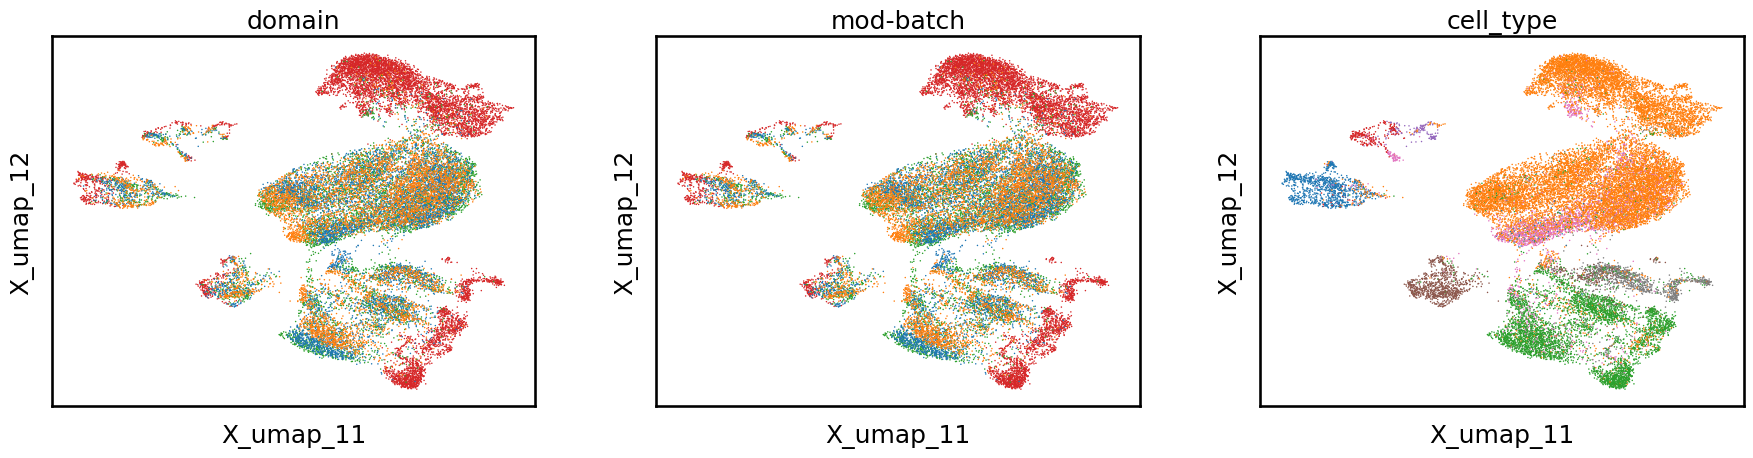

In [31]:
sc.pl.embedding(ad_mosaic, basis='X_umap_1', color=['domain', 'mod-batch', 'cell_type'], legend_loc='right margin')

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


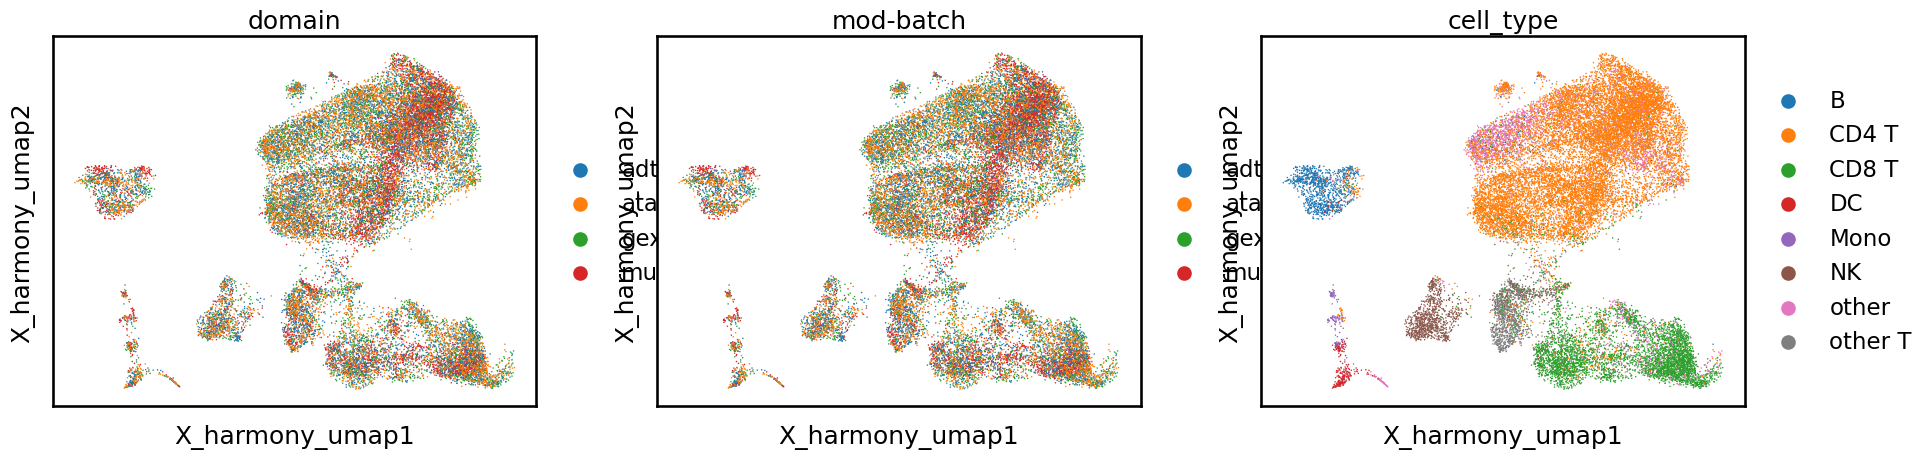

In [32]:
sc.pl.embedding(ad_mosaic, basis='X_harmony_umap', color=['domain', 'mod-batch', 'cell_type'], legend_loc='right margin')

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/t

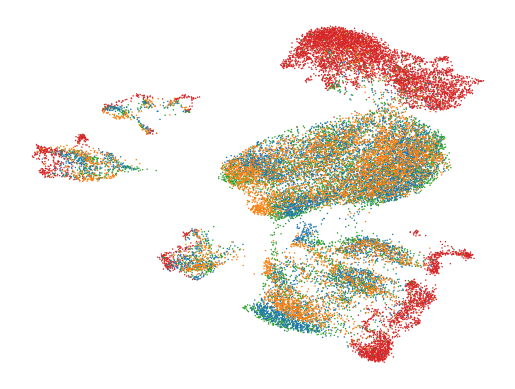

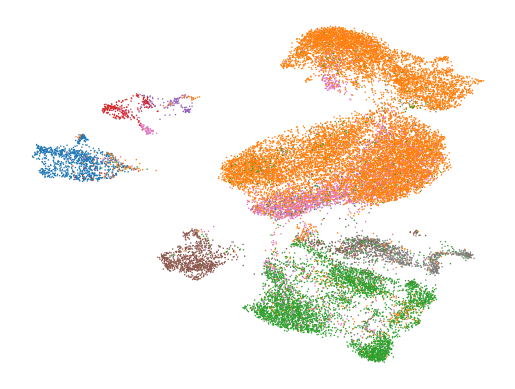

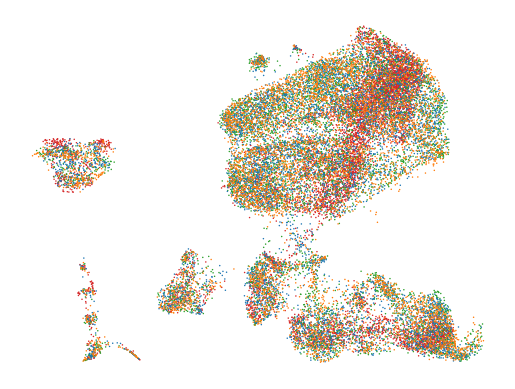

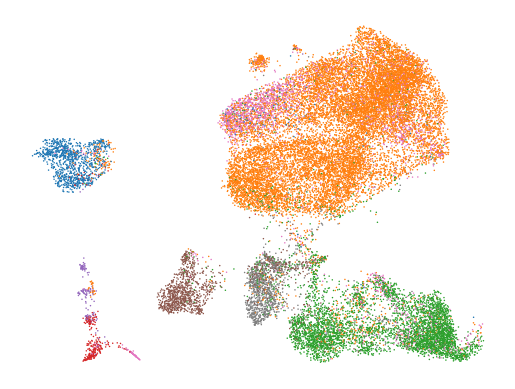

In [34]:
save_umap(ad_mosaic, 'X_umap_1', ['domain', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec2/umap', 
          prefix_name='clue_case2_dogma')

save_umap(ad_mosaic, 'X_harmony_umap', ['domain', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec2/umap', 
          prefix_name='clue-harmony_case2_dogma')

In [35]:
np.save(join(umap_save_dir, 'clue_case2_dogma_umap.npy'), ad_mosaic.obsm['X_umap_1'])
np.save(join(umap_save_dir, 'clue-harmony_case2_dogma_umap.npy'), ad_mosaic.obsm['X_harmony_umap'])